# SHAKTI FEniCS code

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from dolfinx.mesh import create_rectangle, CellType, DiagonalType
from dolfinx.fem import Constant,Function, FunctionSpace,Expression,assemble_scalar,form
from ufl import dx
from params import L,W,nx,ny,rho_i,g,H,nu,omega,nxi,nyi,X,Y,rho_w,x_i
from petsc4py import PETSc
from solvers import time_stepping
from mpi4py import MPI
from fem_space import mixed_space, vector_space
from post_process import interp

Define domain:

In [3]:
p0 = [-0.5*L,-0.5*W]
p1 = [0.5*L,0.5*W]
domain = create_rectangle(MPI.COMM_WORLD,[p0,p1], [nx, ny],cell_type=CellType.triangle) #,diagonal=DiagonalType.crossed)

In [4]:
slope = 0.02
# define bed geometry
V0 = FunctionSpace(domain, ("CG", 1))
bed = lambda x: slope*(x[0]+0.5*L)
z_b = Function(V0)
z_b.interpolate(bed)

In [5]:
b0 = 0.01
N0 = rho_i*g*H
qx0 = 0
qy0 = 0

# define initial conditions
V = mixed_space(domain)
initial = Function(V)
initial.sub(0).interpolate(lambda x:b0+0*x[0])           # initial b
initial.sub(1).interpolate(lambda x: N0 + 0*x[0]) # initial N
initial.sub(2).sub(0).interpolate(lambda x:1e-3+0*x[0])  # initial qx
initial.sub(2).sub(1).interpolate(lambda x:qy0+0*x[0])   # initial qy

# define moulin source term
moulin = Function(V0)
sigma = 20/3.
moulin_ = lambda x: np.exp(1)**(-(x[0]**2+x[1]**2)/sigma**2)
moulin.interpolate(moulin_)
scale = assemble_scalar(form(moulin*dx))
moulin = 10*moulin/scale 

# define water flux boundary condition (Neumann)
V_q = vector_space(domain)
q_in = Function(V_q)
q_in.sub(0).interpolate(lambda x:qx0+0*x[0])
q_in.sub(1).interpolate(lambda x:0+0*x[0])

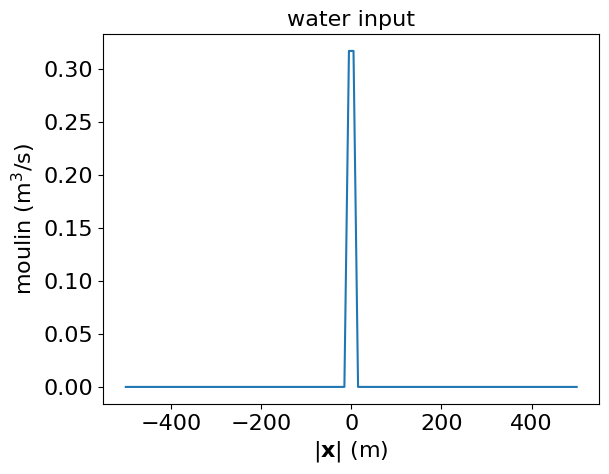

In [6]:
# plot the water input
plt.plot(x_i,moulin_(X))
plt.xlabel(r'$|\mathbf{x}|$ (m)',fontsize=16)
plt.ylabel(r'moulin (m$^3$/s)',fontsize=16)
plt.title(r'water input',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
plt.close()

In [7]:
# define timesteps
days = 10
t_final = (days/365)*3.154e7
timesteps = np.linspace(0,t_final,int(days*100))

b,N,qx,qy = time_stepping(domain,initial,timesteps,z_b,q_in,moulin)

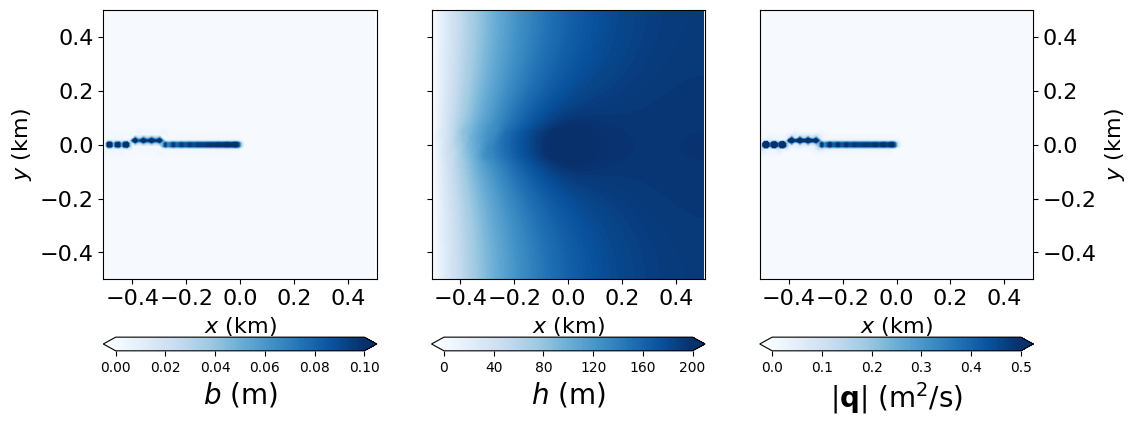

In [8]:
%matplotlib inline
#import matplotlib as mpl
# mpl.use('agg')

# get water flow speed
q_m = np.sqrt(qx**2+qy**2)

# get hydraulic head
head = bed([X]) + (rho_i/rho_w)*H  - N/(rho_w*g)

for i in [-1]:#range(timesteps.size):
    # print('saved image '+str(i+1)+' out of '+str(timesteps.size)+' \r',end='')

    plt.figure(figsize=(12,5))
    plt.subplot(131)
    b_i = b[i,:,:]
    plt.contourf(X/1e3,Y/1e3,b_i,levels=np.linspace(0,0.1,100),cmap='Blues',extend='both')
    cbar = plt.colorbar(orientation='horizontal',ticks=np.linspace(0,0.1,6))
    cbar.set_label(r'$b$ (m)',fontsize=20)
    plt.xlabel(r'$x$ (km)',fontsize=16)
    plt.ylabel(r'$y$ (km)',fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.axis('equal')

    plt.subplot(132)
    head_i = head[i,:,:]
    # N_i = N[i,:,:]
    plt.contourf(X/1e3,Y/1e3,head_i,levels=np.linspace(0,200,100),cmap='Blues',extend='both')
    # plt.contourf(X/1e3,Y/1e3,N_i/1e6,levels=np.linspace(0,5,100),cmap='Blues',extend='both')
    cbar = plt.colorbar(orientation='horizontal',ticks=np.linspace(0,200,6))
    # cbar = plt.colorbar(orientation='horizontal',ticks=np.linspace(0,5,6))
    cbar.set_label(r'$h$ (m)',fontsize=20)
    # cbar.set_label(r'$N$ (MPa)',fontsize=20)
    plt.xlabel(r'$x$ (km)',fontsize=16)
    plt.xticks(fontsize=16)
    plt.gca().yaxis.set_ticklabels([])
    plt.axis('equal')

    plt.subplot(133)
    q_i = q_m[i,:,:]
    plt.contourf(X/1e3,Y/1e3,q_i,cmap='Blues',levels=np.linspace(0,0.5,100),extend='both')
    cbar = plt.colorbar(orientation='horizontal',ticks=np.linspace(0,0.5,6))
    cbar.set_label(r'$|\mathbf{q}|$ (m$^2$/s)',fontsize=20)
    plt.gca().yaxis.set_label_position("right")
    plt.gca().yaxis.tick_right()
    plt.xlabel(r'$x$ (km)',fontsize=16)
    plt.ylabel(r'$y$ (km)',fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.axis('equal')
    # plt.savefig('./movie/'+str(i))
    plt.show()
    plt.close()